## Siamese Neural Networks 
### for Supervised Clustering of High Dimensional Spaces

In [1]:
!python -V
!which python

Python 3.6.10
/Users/seanmacrae/mobius/.venv/bin/python


In [2]:
sql = """
SELECT
  audience.*,
  latest.address,
  latest.city,
  latest.state,
  latest.zipcode,
  latest.county,
  latest.metroName,
  latest.longitude,
  latest.latitude,
  realEstateInvestor,
  personalInvestor
FROM `tranquil-garage-139216.people.audience_dbusa_features` dbusa
LEFT JOIN `tranquil-garage-139216.people.audience_20201012` audience ON audience.id = dbusa.id
LEFT JOIN `tranquil-garage-139216.people.latest` latest ON latest.id = audience.id
WHERE logsumHealthCause > 0 AND logAccreditedNetWorth > 6
"""

In [3]:
# !pip install loaderbot

In [4]:
cats = ['recentPurchaseDate',
            'recentDivorceDate',
            'recentDeathDate',
            'isBoatOwner',
            'isPlaneOwner',
            'recentPhilanthropicGiftDate',
            'recentFoundationAssociationDate',
            'isFoundationOfficer',
            'recentFoundationTrusteeDate',
            'hasFoundationAssociation',
            'hasCharityBoardMember',
            'hasCharityOfficer',
            'isMultiPropertyOwner',
            'isRentalPropertyOwner',
            'isHouseholdDebt',
            'recentPoliticalContributionDate',
            'isSmallBusinessOwner',
            'isCharityBoardMember',
            'isCharityOfficer',
            'hasTrust',
            'politicalDemocrat',
            'politicalRepublican',
            'politicalIndependent',
            'isSFROwner',
            'isCondoOwner',
            'isRuralResidenceOwner',
            'isArtsCause',
            'isEducationCause',
            'isEnvironmentalCause',
            'isAnimalCause',
            'isHealthCause',
            'isHumanServicesCause',
            'isInternationalCause',
            'isSocialBenefitCause',
            'isReligiousCause',
            'is990Donation',
            'isCoopDonation',
            'isFECContribution',
            'isStateContribution',
            'lux_athletic',
            'lux_flight',
            'lux_goods',
            'lux_travel',
            'zipcode',
            'realEstateInvestor',
            'personalInvestor']

dtype = {k: str for k in cats}

In [5]:
import loaderbot.big_query as bq
from google.cloud import bigquery, storage

bigquery_client = bigquery.Client(project="tranquil-garage-139216")
storage_client = storage.Client(project="tranquil-garage-139216")

raw_data = bq.query_table_and_cache(
            sql=sql,
            df_dtype=dtype,
            bigquery_client=bigquery_client,
            storage_client=storage_client,
    )

/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [6]:
raw_data.shape

(584245, 125)

In [7]:
raw_data.head()

,id,logNetWorth,logAccreditedNetWorth,recentPurchaseDate,recentDivorceDate,recentDeathDate,isBoatOwner,isPlaneOwner,recentPhilanthropicGiftDate,recentFoundationAssociationDate,...,address,city,state,zipcode,county,metroName,longitude,latitude,realEstateInvestor,personalInvestor
0,17dfe362f2a52fad7fc30688f883ed3c,6.317667,6.035153,0,0,0,0,0,0,0,...,11 WESTRIDGE DR,LAKE OSWEGO,OR,97034,Clackamas,"PORTLAND-VANCOUVER-BEAVERTON, OR-WA",-122.714792,45.393171,0,1
1,f155fadc922eef19d0d3933fe1a53162,6.390421,6.249058,0,0,0,0,0,0,0,...,116 AUGUSTA DR,BROUSSARD,LA,70518,Lafayette,"LAFAYETTE, LA",-91.946955,30.085969,1,1
2,6eb731db91258c929427e86bc5277ab7,6.490808,6.450590,1,0,0,0,0,0,0,...,13400 JUNEAU BLVD,ELM GROVE,WI,53122,Waukesha,"MILWAUKEE-WAUKESHA-WEST ALLIS, WI",-88.079144,43.045960,0,1
3,dedaab4d0d5c038715a1020260eeca79,6.455325,6.275680,0,0,0,0,0,0,0,...,278 FINCH LN,SAUNDERSTOWN,RI,02874,Washington,"PROVIDENCE-NEW BEDFORD-FALL RIVER, RI-MA",-71.476905,41.529689,0,0
4,afca333d749f7bcc869b3c9c11916733,6.661214,6.555541,0,0,0,0,0,0,0,...,1571 HICKS AVE,SAN JOSE,CA,95125,Santa Clara,"SAN JOSE-SUNNYVALE-SANTA CLARA, CA",-121.905612,37.296508,0,1


In [9]:
import numpy as np

def make_label(donation_amount):
    if donation_amount <= np.log10(1_000):
        return "low"
    elif (donation_amount > np.log10(1_000)) & (donation_amount <= np.log10(25_000)):
        return "mid"
    elif (donation_amount > np.log10(25_000)) & (donation_amount <= np.log10(80_000)):
        return "high"
    elif donation_amount > np.log10(80_000):
        return "windfall"
    
# engineer a donor label
raw_data["label"] = raw_data["logsumHealthCause"].apply(lambda x: make_label(x))

# shuffle the data
raw_data = raw_data.sample(frac=1, random_state=42)

In [10]:
from sklearn.model_selection import train_test_split

df, _ = train_test_split(
    raw_data,
    test_size=0.97,
    stratify=raw_data["label"])

In [11]:
df.shape

(17527, 126)

In [12]:
df["label"].value_counts() / len(df)

low         0.908085
mid         0.080790
high        0.005648
windfall    0.005477
Name: label, dtype: float64

## Tabular Learner

Before we train the Tabular Siamese Learner we will train baseline Tabular Learner for species classification... (why do we do this, exactly? can we just instantiate a Tabular Siamese Learner without a baseline Tabular Learner ???)

Ah yes, to init a new `TabularSiameseModel` we need to provide an `encoder` and `head` and the Tabular Learner will act as the `encoder` we init the `TabularSiameseModel` with.

In [13]:
df.head()

,id,logNetWorth,logAccreditedNetWorth,recentPurchaseDate,recentDivorceDate,recentDeathDate,isBoatOwner,isPlaneOwner,recentPhilanthropicGiftDate,recentFoundationAssociationDate,...,city,state,zipcode,county,metroName,longitude,latitude,realEstateInvestor,personalInvestor,label
405469,f45b815922ec73c9b87ba28e9fcd9f5c,6.296957,6.161656,0,0,0,0,0,0,0,...,LIVINGSTON,NJ,07039,Essex,"NEW YORK-NORTHERN NEW JERSEY-LONG ISLAND, NY-N...",-74.327846,40.813701,0,1,low
292804,cb25f31a9b4369b1e94f7665b9378a66,7.320433,7.276668,0,0,0,0,0,1,0,...,RYE,NY,10580,Westchester,"NEW YORK-NORTHERN NEW JERSEY-LONG ISLAND, NY-N...",-73.688666,40.957544,1,1,low
556053,ec352844044c07c66403d0137522816e,7.042574,7.005944,0,0,0,0,0,0,0,...,CYPRESS,CA,90630,Orange,"LOS ANGELES-LONG BEACH-SANTA ANA, CA",-118.058113,33.826129,0,0,low
187067,aa2539ae7141557826f7ab2bd7c23be5,6.435676,6.388808,0,0,0,0,0,0,0,...,NORTHVILLE,MI,48168,Wayne,"DETROIT-WARREN-LIVONIA, MI",-83.467590,42.418316,0,0,low
206044,bc423866f9c3ebdfc063335ca938a6ce,6.219164,6.049368,0,0,0,0,0,0,0,...,BROOMFIELD,CO,80023,Broomfield,"DENVER-AURORA-BROOMFIELD, CO",-105.039331,39.986084,0,1,low


In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.10,
    stratify=df["label"])

df = df_train.copy()

exclude_vars = ["id", 
                "longitude", 
                "latitude", 
                "label",
                "address",
                'logMaxDonationAmount',
                'logSumDonationAmount',
                'isHealthCause',
                'isCoopDonation',
                'logsumHealthCause',
                'logMaxDonationAmount_1year',
                'logSumDonationAmount_1year',
                'logsumCOOPDonation_1year',
                'logMaxDonationAmount_3year',
                'logSumDonationAmount_3year',
                'logsumCOOPDonation_3year',
                'logMaxDonationAmount_5year',
                'logSumDonationAmount_5year',
                'logsumCOOPDonation_5year']

In [15]:
from fastai.tabular.all import CategoryBlock
                                
y_names = ["label"]
y_block = CategoryBlock()

In [16]:
from mobius.utils import emb_sz_rule

cat_names = [x for x in df.select_dtypes(exclude=['int', 'float']).columns if x != y_names]
cat_names = [x for x in cat_names if x not in exclude_vars]

# calc embedding sizes for each categorical feature
emb_szs = {k: emb_sz_rule(len(df[k].unique())) for k in cat_names}
emb_szs

{'recentPurchaseDate': 2,
 'recentDivorceDate': 2,
 'recentDeathDate': 2,
 'isBoatOwner': 2,
 'isPlaneOwner': 2,
 'recentPhilanthropicGiftDate': 2,
 'recentFoundationAssociationDate': 2,
 'isFoundationOfficer': 2,
 'recentFoundationTrusteeDate': 2,
 'hasFoundationAssociation': 2,
 'hasCharityBoardMember': 2,
 'hasCharityOfficer': 2,
 'isMultiPropertyOwner': 2,
 'isRentalPropertyOwner': 2,
 'isHouseholdDebt': 2,
 'recentPoliticalContributionDate': 2,
 'isSmallBusinessOwner': 2,
 'isCharityBoardMember': 2,
 'isCharityOfficer': 2,
 'hasTrust': 2,
 'politicalDemocrat': 2,
 'politicalRepublican': 2,
 'politicalIndependent': 2,
 'isSFROwner': 2,
 'isCondoOwner': 2,
 'isRuralResidenceOwner': 2,
 'isArtsCause': 2,
 'isEducationCause': 2,
 'isEnvironmentalCause': 2,
 'isAnimalCause': 2,
 'isHumanServicesCause': 2,
 'isInternationalCause': 2,
 'isSocialBenefitCause': 2,
 'isReligiousCause': 2,
 'is990Donation': 2,
 'isFECContribution': 2,
 'isStateContribution': 2,
 'lux_athletic': 2,
 'lux_flig

In [17]:
import numpy as np

cont_names = [x for x in df.select_dtypes([np.number]).columns if x != y_names]
cont_names = [x for x in cont_names if x not in exclude_vars]
cont_names

['logNetWorth',
 'logAccreditedNetWorth',
 'logTotalHouseholdDebt',
 'recentSecTransactionAcquired',
 'recentSecTransactionDisposed',
 'primaryPropertyLoanToValue',
 'logPrimaryPropertyAvm',
 'femaleCount',
 'maleCount',
 'minHouseholdAge',
 'avgHouseholdAge',
 'maxHouseholdAge',
 'metroNameRank',
 'propertyCount',
 'logMaxPropertyAvm',
 'logSumPropertyAvm',
 'maxPropertySqft',
 'maxBedrooms',
 'primaryPropertySqft',
 'primaryPropertyYearsOwned',
 'minPropertyYearsOwned',
 'maxPropertyYearsOwned',
 'logsumArtsCause',
 'logsumEducationCause',
 'logsumEnvironmentalCause',
 'logsumAnimalCause',
 'logsumHumanServicesCause',
 'logsumInternationalCause',
 'logsumSocialBenefitCause',
 'logsumReligiousCause',
 'logsum990Donation',
 'logsumCOOPDonation',
 'logsumFECDonation',
 'logsumStateContribution',
 'logmax990Donation',
 'logmaxCOOPDonation',
 'logmaxFECDonation',
 'logmaxStateContribution',
 'countNumCharities',
 'logsumFECDonation_1year',
 'logsumStateContribution_1year',
 'countNumChari

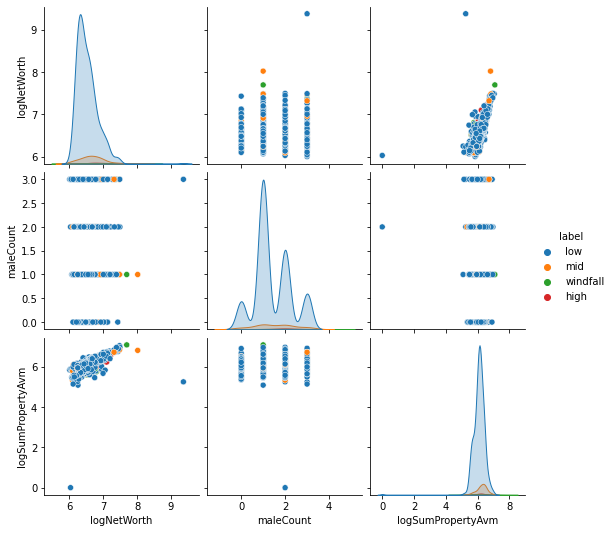

In [18]:
import seaborn as sns

sns.pairplot(df[["logNetWorth", "maleCount", "logSumPropertyAvm", "label"]].sample(frac=0.05), hue='label')

In [19]:
from fastai.tabular.all import (Categorify, CategoryBlock, FillMissing,
                                Normalize, TabDataLoader, TabularPandas,
                                tabular_config, tabular_learner)

procs = [FillMissing, Categorify, Normalize]

In [20]:
from fastai.data.core import range_of
from fastai.tabular.all import RandomSplitter, TrainTestSplitter

# # train/test split
# splits = RandomSplitter(valid_pct=0.20)(range_of(df))

splits = TrainTestSplitter(test_size=0.20, 
                           train_size=0.80, 
                           random_state=None, 
                           stratify=df["label"].values, 
                           shuffle=True)(range_of(df))

In [21]:
tabular_pandas = TabularPandas(
        df,
        procs=procs,
        cat_names=cat_names,
        cont_names=cont_names,
        y_names=y_names,
        y_block=y_block,
        splits=splits,
        device="cpu")

In [22]:
# from mobius.samplers import ImbalancedDatasetSampler

trn_dl = TabDataLoader(
    tabular_pandas.train,
    bs=128,
    shuffle=True,
    drop_last=True,)

val_dl = TabDataLoader(
    tabular_pandas.valid,
    bs=128,)

In [23]:
from fastai.data.core import DataLoaders

dls = DataLoaders(trn_dl, val_dl)

print("Sample batch:")
dls.one_batch()

Sample batch:


(tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 2, 2, 2],
         [1, 1, 1,  ..., 2, 2, 2],
         ...,
         [1, 1, 1,  ..., 2, 2, 2],
         [1, 1, 1,  ..., 2, 2, 2],
         [2, 1, 1,  ..., 1, 1, 1]]),
 tensor([[-0.3734, -0.5990,  0.7319,  ..., -0.1106, -0.7962, -1.3623],
         [-1.0431, -1.1597,  0.6394,  ..., -0.1106, -0.3701, -0.7976],
         [-0.5684, -0.4628,  0.6007,  ..., -0.1106,  0.5349, -0.4138],
         ...,
         [-0.5598, -1.1214,  0.2971,  ..., -0.1106, -0.1804, -0.4054],
         [ 0.0355,  0.0524,  0.4907,  ..., -0.1106, -0.1627,  0.5588],
         [ 3.1894,  3.2652,  0.7179,  ..., -0.1106,  0.7661,  1.0083]]),
 tensor([[2],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [

In [24]:
from fastai.metrics import F1Score, Precision, Recall, accuracy

# load the tabular_pandas data through the tabular_learner
layers = [2048, 1024, 32, 2]

# tabular learner configuration
config = tabular_config(ps=[0.01, 0.01, 0.01, 0.01], embed_p=0.01)

# create tabular learner
learn = tabular_learner(
    dls,
    layers=layers,
    emb_szs=emb_szs,
    config=config,
    metrics=[accuracy,
             Precision(average='macro'),
             Recall(average='macro'),
             F1Score(average='macro')])

In [25]:
learn.fit_one_cycle(n_epoch=12)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.806828,0.756364,0.904913,0.302991,0.261631,0.260999,00:12
1,0.677677,0.655627,0.895404,0.302116,0.278662,0.283925,00:12
2,0.506549,0.485280,0.902377,0.327243,0.304697,0.312471,00:12
3,0.363703,0.376437,0.886846,0.315049,0.313818,0.314320,00:12
4,0.277687,0.327707,0.888431,0.327265,0.332117,0.329668,00:12
5,0.212103,0.832479,0.903011,0.343192,0.345062,0.344113,00:13
6,0.178462,0.317727,0.894453,0.331204,0.332882,0.332026,00:13
7,0.148735,0.292780,0.902694,0.345795,0.345868,0.345791,00:13
8,0.129037,0.280993,0.900475,0.342915,0.341685,0.342223,00:12
9,0.109970,0.324098,0.907448,0.353913,0.344497,0.348674,00:12


/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.6/s

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.092075,0.312546,0.908082,0.355712,0.350031,0.352615,00:12
1,0.092115,0.303426,0.907765,0.355315,0.350837,0.352882,00:12
2,0.095123,0.304687,0.906815,0.353395,0.347895,0.350393,00:12
3,0.093241,0.296073,0.908399,0.355780,0.346546,0.350658,00:12
4,0.092503,0.306621,0.907765,0.355072,0.349050,0.351783,00:12


/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.6/s

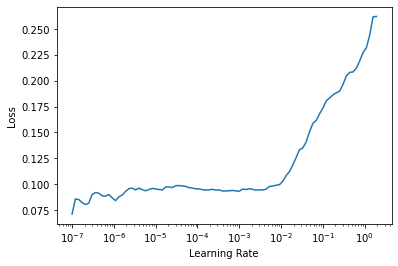

In [26]:
lr_min, _ = learn.lr_find()
learn.fit(n_epoch=5, lr=lr_min)

In [27]:
learn.export("tabular_learn.pkl")

In [28]:
from mobius.calibration import ModelWithTemperature

scaled_model = ModelWithTemperature(learn.model)
scaled_model.set_temperature(val_dl)
learn.model = scaled_model.model

Before temperature - NLL: 0.307, ECE: 0.035
Optimal temperature: 1.390
After temperature - NLL: 0.276, ECE: 0.021


In [29]:
# true species labels
y_true=learn.dls.valid.items["label"]

# model scores and species predictions
y_scores, *_ = learn.get_preds(dl=val_dl)
preds = np.argmax(y_scores, 1).numpy()

/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print("First 20 species labels and predictions")
list(zip(y_true, preds))[:10]

First 20 species labels and predictions


[(1, 1),
 (1, 1),
 (2, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1)]

In [31]:
(y_true == preds).sum() / len(y_true)

0.9077654516640253

In [32]:
# TODO: update roc-it with MultiClassClassification...

# clf_metrics = BinaryClassification(
#     y_true=y_true, y_scores=y_scores)

# ths = clf_metrics.recall_curve(0.95)

# clf_metrics.plot_confusion_matrix(
#     ths=0.50,
#     normalize=None,
#     save_path=f'{hyperparams["artifact_dir"]}/cm.png')

# clf_metrics.plot_pr_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/pr_curve.png')

# clf_metrics.plot_roc_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/roc_curve.png')

## Siamese Net

To init a new `TabularSiameseDataset` object, we only need a `tabular_pandas` object from the fast.ai library.

In [33]:
from mobius.datasets import TabularSiameseDataset

# sds = TabularSiameseDataset(tabular_pandas)
train_ds = TabularSiameseDataset(tabular_pandas.train)
valid_ds = TabularSiameseDataset(tabular_pandas.valid)

In [34]:
train_ds.__getitem__(10)

((tensor([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             2,    2,    2,    1,    1,    1,    1,    1,    1,    1,    1,    2,
             2,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1, 1034,    5, 3936,  352,  245,    1,    1,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1]),
  tensor([ 1.1701,  1.3202,  0.6772, -0.0598, -0.0488,  0.3353,  0.1402, -0.5489,
          -0.5302, -1.3684, -0.8597,  1.8885, -0.7169,  4.0904,  0.0478,  1.1992,
          -0.0183, -0.0675, -0.0557,  0.2986, -1.1724,  0.7165, -0.1317, -0.3739,
          -0.3637, -0.2024, -0.4042, -0.0871, -0.2067, -0.1311, -0.0860, -0.5462,
          -0.7929, -0.6210, -0.0861, -0.2121, -0.7926, -0.6240, -0.6553, -0.6157,
          -0.1909, -0.3330,  0.0000, -0.6729, -0.3992,  0.7263, -0.0694, -0.7092,
          -0.4515,  0.2737,  1.8361,  2.5284, -0.0

In [35]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=32, device='cpu', num_workers=0)

Siamese net encoder is the body of the Tabular net we just trained.

In [36]:
import copy

encoder = copy.copy(learn)
encoder.model.layers = learn.model.layers[:-1]
encoder_model = encoder.model

We create a new head that doubles the input shape to the last layer of the trained Tabular net, since the loss function will now compare 2 penguins. The size of the output shape is set by...???

In [37]:
from fastai.layers import LinBnDrop

head = LinBnDrop(n_in=layers[-1]*2,
    n_out=8,  # size of output space
    bn=True,
    act=None)

In [38]:
from mobius.models import TabularSiameseModel

model = TabularSiameseModel(encoder_model, head)

In [39]:
from fastai.torch_basics import params
from mobius.losses import ContrastiveLoss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def contrastive_loss_func(out, targ):
    return ContrastiveLoss(margin=0.10)(out, targ.long())

In [40]:
from fastai.learner import Learner

siamese_learner = Learner(dls,
    model,
    model_dir=".",
    loss_func=contrastive_loss_func,
    splitter=siamese_splitter)

In [41]:
# %debug
siamese_learner.freeze()
siamese_learner.fit_one_cycle(n_epoch=5)

epoch,train_loss,valid_loss,time
0,3.386249,4.287244,23:50
1,0.976246,1.322839,23:22
2,0.240301,0.251905,23:15
3,0.096841,0.121199,23:42
4,0.116847,0.178102,24:47


In [43]:
# siamese_learner.unfreeze()
# lr_min, _ = siamese_learner.lr_find()
# siamese_learner.fit(n_epoch=5, lr=lr_min)

In [46]:
# siamese_learner.save("snn_margin_20")

In [47]:

from tqdm import tqdm

train_encoded = list()
for i in tqdm(range(len(dls.train_ds.tabular_pandas))):
    # get ith point from the training set
    p, _, _ = dls.train_ds.get_items(i, 0)

    # rehsape into mini-batch size 1
    p = p[0].reshape(1, -1), p[1].reshape(1, -1)

    # encode the household into output embedding space
    p_encode = siamese_learner.model.encode(p)
    train_encoded.append(p_encode)
    
ids = dls.train.get_idxs()
y_train_labels = dls.train.tabular_pandas["label"]

  0%|          | 0/12619 [00:00<?, ?it/s]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 59])

In [ ]:
import torch
import pandas as pd

train_encoded_df = pd.DataFrame(torch.stack(train_encoded).squeeze())

In [ ]:
train_encoded_df

In [ ]:
# train_encoded_df[0].values

In [ ]:
!pip install seaborn

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(x=train_encoded_df[0].values,
                y=train_encoded_df[1].values,
                hue=y_train_labels, 
                legend='full', 
                palette="tab10")

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE
sns.set(rc={'figure.figsize':(11.7,8.27)})

tsne = TSNE()
encoded_train_tsne = tsne.fit_transform(train_encoded_df.values)

In [ ]:
sns.scatterplot(x=encoded_train_tsne[:,0],
                y=encoded_train_tsne[:,1],
                hue=y_train_labels, 
                legend='full', 
                palette="tab10")

In [ ]:
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    "learning_rate": [1e-1, 1e-2, 1e-3],
    "max_depth":[3, 5, 8, 10],
    "n_estimators":[50, 100]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, scoring=f1, cv=5, n_jobs=-1)
clf.fit(train_encoded_df.values, y_train_labels)

print(clf.score(train_encoded_df.values, y_train_labels))
print(clf.best_params_)

## Experiment: Clustering Approach

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

# # TODO: grid search this...
# clustering = AgglomerativeClustering(
#     n_clusters=8, 
#     affinity="l1", 
#     linkage="complete").\
# fit(train_encoded_df.values)

# clustering.labels_

In [ ]:
# res = pd.DataFrame(zip(y_train_labels, clustering.labels_), columns=["true", "pred"])

In [ ]:
# res_counts = res.groupby(["true", "pred"]).apply(len).reset_index()
# res_counts.columns = ["true", "pred", "count"]

In [ ]:
# # TODO: order the below for loops to start with largest clusters first
# res_counts

In [ ]:
# cluster2label = dict()
# for pred in res_counts["pred"].unique():
#     thingy = res_counts[res_counts["pred"] == pred].sort_values("count", ascending=False)
    
#     for label in thingy["true"].values:
#         if label not in cluster2label.values():
#             cluster2label.update({pred: label})
    
# for pred in res_counts["pred"].unique():
#     if pred not in cluster2label.keys():
#         cluster2label.update({pred: None})

In [ ]:
# cluster2label

In [ ]:
# cluster_groups = res.groupby(["true", "pred"]).apply(len).reset_index().values
# cluster_groups

## Validation Set

In [ ]:
from tqdm import tqdm

valid_encoded = list()
for i in tqdm(range(len(dls.valid_ds.tabular_pandas))):
    # get ith point from the training set
    p, _, _ = dls.valid_ds.get_items(i, 0)

    # rehsape into mini-batch size 1
    p = p[0].reshape(1, -1), p[1].reshape(1, -1)

    # encode the household into output embedding space
    p_encode = siamese_learner.model.encode(p)
    valid_encoded.append(p_encode)
    
valid_ids = dls.valid.get_idxs()
y_valid_labels = dls.valid.tabular_pandas["loan_status"]

In [ ]:
valid_encoded_df = pd.DataFrame(torch.stack(valid_encoded).squeeze())

In [ ]:
encoded_valid_tsne = tsne.fit_transform(valid_encoded_df.values)

In [ ]:
sns.scatterplot(x=encoded_valid_tsne[:,0],
                y=encoded_valid_tsne[:,1],
                hue=y_valid_labels, 
                legend='full', 
                palette="tab10")

In [ ]:
res = pd.DataFrame(zip(clf.predict(valid_encoded_df), y_valid_labels), columns=["pred", "true"])

In [ ]:
(res["pred"] == res["true"]).sum() / len(res)

In [ ]:
res

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as multiclass_eval

prec, recall, fbeta, _ = multiclass_eval(res["true"].values, res["pred"].values, average="macro")

f"precision {prec}, recall {recall}, fbeta {fbeta}"

In [ ]:
# import umap
# import matplotlib.pyplot as plt

# reducer = umap.UMAP()

# embedding = reducer.fit_transform(valid_encoded_df.values)
# embedding.shape

# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     c=[sns.color_palette()[x] for x in y_valid_labels.values])

# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the LC Loans', fontsize=24)